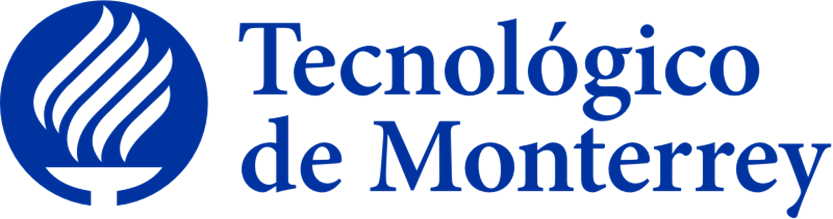

# Visión computacional para imágenes y video

## Entregable 5.3 algoritmos de mejoramiento de imágenes en el dominio de Fourier

### Profesor titular: Dr. Gilberto Ochoa Ruiz
### Profesor asistente: Mtra. Yetnalezi Quintas Ruiz

* Alejandro Hahn Gallegos   A01561774
* Bernardo Mijangos Flores. A01793654
* Christian Suarez Gil .  A01793933
* Jhon Edison Muñoz Burgos.  A01793659
* Irvin Antero Gómez Esquivel . A00361034


In [65]:
# importamos las librerias

from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import plotly.express as px
from typing import List
from enum import Enum
from math import sqrt,exp
from   matplotlib.colors import LogNorm
from   scipy.fftpack     import fft2,ifft2,fftshift,ifftshift
from   scipy.ndimage     import gaussian_filter
from   scipy.signal      import fftconvolve


#  a) Investigar una aplicación de mejoramiento de imágenes usando transformada de Fourier usando filtro pasabajas. Realizar una demo sencilla en Google collab. De preferencia probar los tres tipo de filtros básicos

In [66]:
# montamos el drive de google colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
#obtenemos la imagen a procesar
X = cv.imread("/content/drive/MyDrive/Imagenes/NinosPresos.jpg",0)



## Funciones de visualización

In [68]:
def surface_plot (matrix, **kwargs):
    # Adquirimos las cordenas de la matrix
    # X corresponden a las columnas y Y a las filas
    (x, y) = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

#Se va a ejecutar la funcion fftshift, la frencuencia se encuentra centrada y por medio de esta funcion envia a las esquinas la parte central.
#Despues de  hacer la función fftshift ya podemos hacer la transformada de fourier debido que las frecuencias coinciden.

def plot_spectrum(X_ft,centered=True):
    # A logarithmic colormap
    if centered:
      X_ftc = fftshift(X_ft)
    else:
      X_ftc = X_ft
    plt.imshow(np.abs(X_ftc), norm=LogNorm(vmin=5))
    plt.colorbar()


## Transformada directa, fftshift, transformada inversa

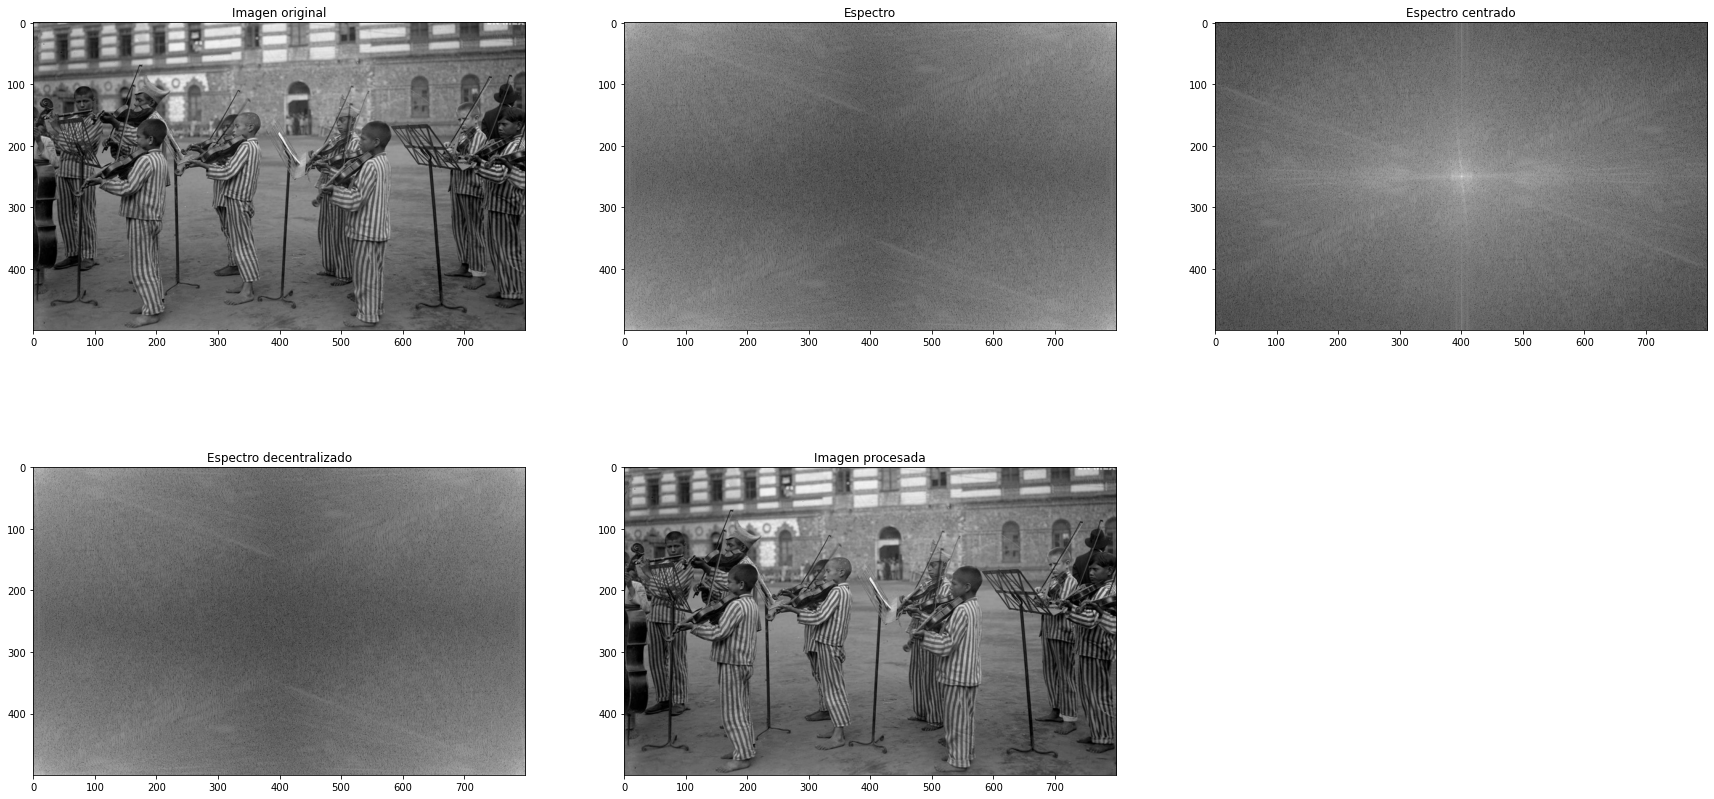

In [69]:
# La imagen original es transformada de ida y de vuelta (sin procesar)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(X, "gray"), plt.title("Imagen original")

X_ft = fft2(X)
plt.subplot(232), plt.imshow(np.log(1+np.abs(X_ft)), "gray"), plt.title("Espectro")

# Aplicamos la funcion Fftshift a la imagen original (Espectro)
X_ftc = fftshift(X_ft)
plt.subplot(233), plt.imshow(np.log(1+np.abs(X_ftc)), "gray"), plt.title("Espectro centrado")

# Aplicamos de nuevo la funcion fftshift a la imagen Espectro.
X_ft_inv = ifftshift(X_ftc)
plt.subplot(234), plt.imshow(np.log(1+np.abs(X_ft_inv)), "gray"), plt.title("Espectro decentralizado")

#Aplicamos la  transformada inversa  de fourier para obtener de nuevo la imagen original
X_new = ifft2(X_ft_inv)
plt.subplot(235), plt.imshow(np.abs(X_new), "gray"), plt.title("Imagen procesada")

plt.show()

En el primer recuadro se observa la imagen original a transformar, despues se realiza un espectro, posteriormente realizamos un "fftshift" al espectro obtenido generando un espectro centralizado, se  observa la frecuencia centralizada, luego de nuevo se genera un fftshift la frecuencia se encuentra en la parte superior izquierda y sus extremos son sus espejos. Por ultimo se realiza la inversa para obtener la imagen procesada. En este caso no estamos utilizando ningun Filtro. 

## Definición de Funciones

In [70]:
#Funcion de Distancia
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

#Filtro Ideal Paso Bajo

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

#Filtro Ideal paso Alto

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

#Filtro Butterworth Paso Bajo

def butterworthLP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

#Filtro Butterworth Paso Alto

def butterworthHP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1-1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

#Filtro Gaussiano Paso Bajo

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

#Filtro Gaussiano Paso Alto

def gaussianHP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 - np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base





##Filtros Low Pass

El pricipal objetivo de los filtros Low Pass es dejar inalterables las bajas frecuencias y atenúa o elimina las altas frecuencias. El resultado en el dominio del espacio consiste en un suavizado: eliminar pequeños detalles y ruidos de la imagen.  Cuanto menor sea el radio el círculo, mayor será el efecto del filtro

## Filtro Ideal  Low Pass

Este filtro suprime las altas frecuencias mayores que un cierto valor D0, que se denomina frecuencia de corte, y deja las demás tal como están.

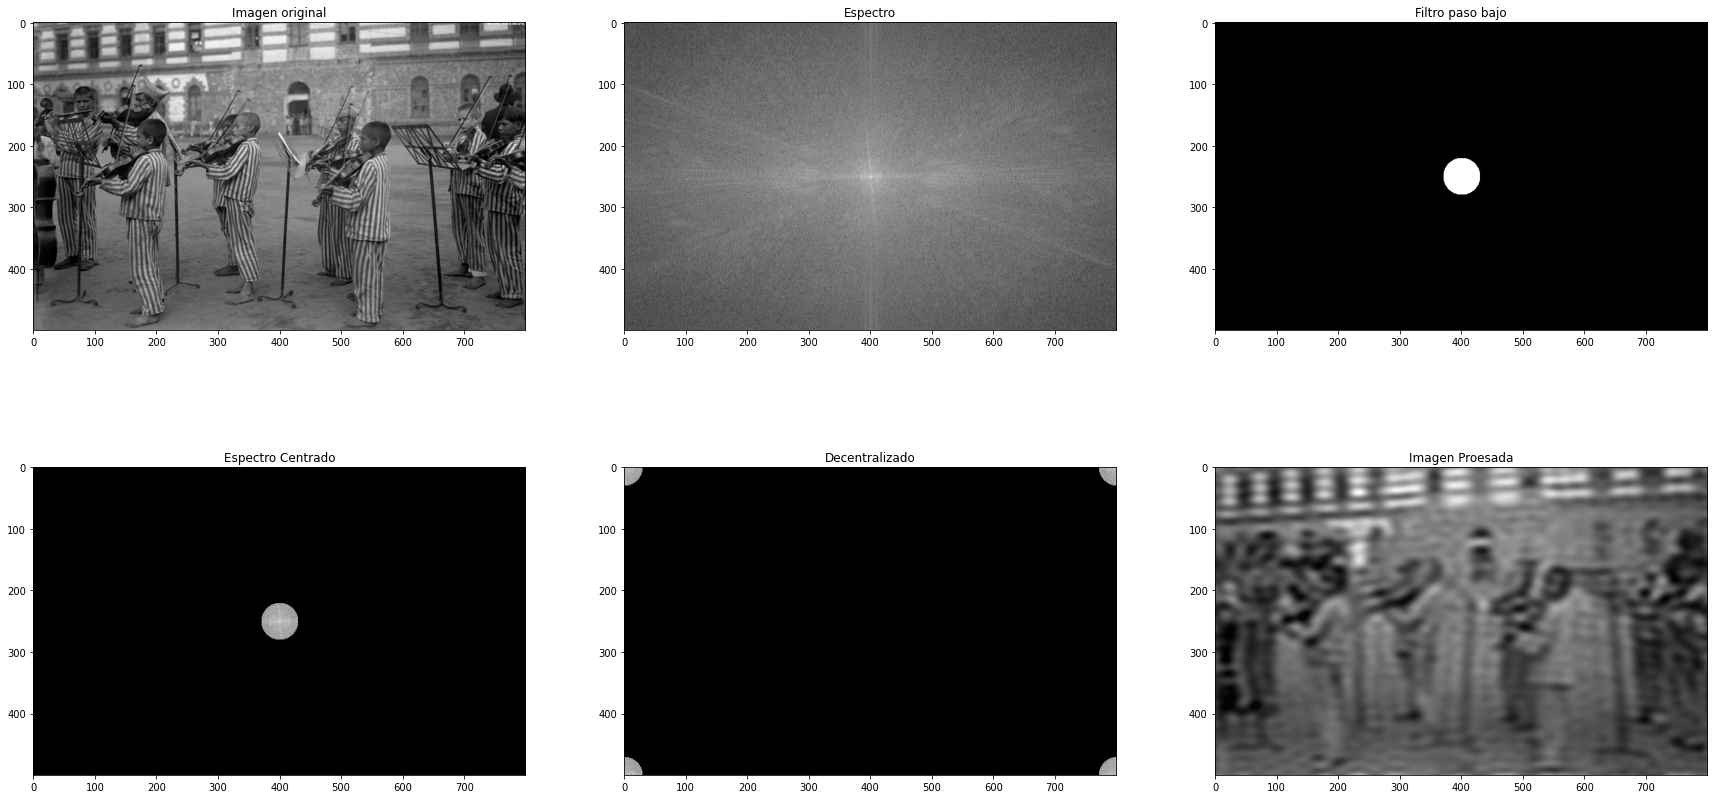

In [71]:
# La imagen original es transformada de ida y de vuelta (sin procesar)

Do = 30 # frecuencia de corte

img = X
original = fft2(img)
center = fftshift(original)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(X, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

LowPass = idealFilterLP(Do,img.shape)
plt.subplot(233), plt.imshow(np.abs(LowPass), "gray"), plt.title("Filtro paso bajo")

LowPassCenter = center * idealFilterLP(Do,img.shape)
plt.subplot(234), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Espectro Centrado")

LowPass = ifftshift(LowPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralizado")

inverse_LowPass = ifft2(LowPass)
plt.subplot(236), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Imagen Proesada")

plt.show()

Cuando la frecuencia de filtro es menor ejemplo para D0=5 Se observa que el radio del circulo es menor y se obtiene un mayor filtrado en la imagen, ocasionando distorcion en la misma. Cuando la frencuencia aumenta no se observa un cambio significativo en la imagen final.

## Filtro Butterworth  Low Pass

El filtro Butterworth no tiene una discontinuidad evidente que establezca una frecuencia de corte bien determinada.

El filtro Butterworth no presenta oscilaciones; para n=2, las oscilaciones son casi imperceptibles; mientras que para n>2, los filtros Butterworth presentan oscilaciones indeseadas Si bien se utilizan diferentes n para el
cálculo del filtro Butterworth, el de segundo orden (n=2) es el que generalmente se elige ya que tiene un buen compromiso entre un filtrado pasa-bajos efectivo y oscilaciones de intensidad aceptable.

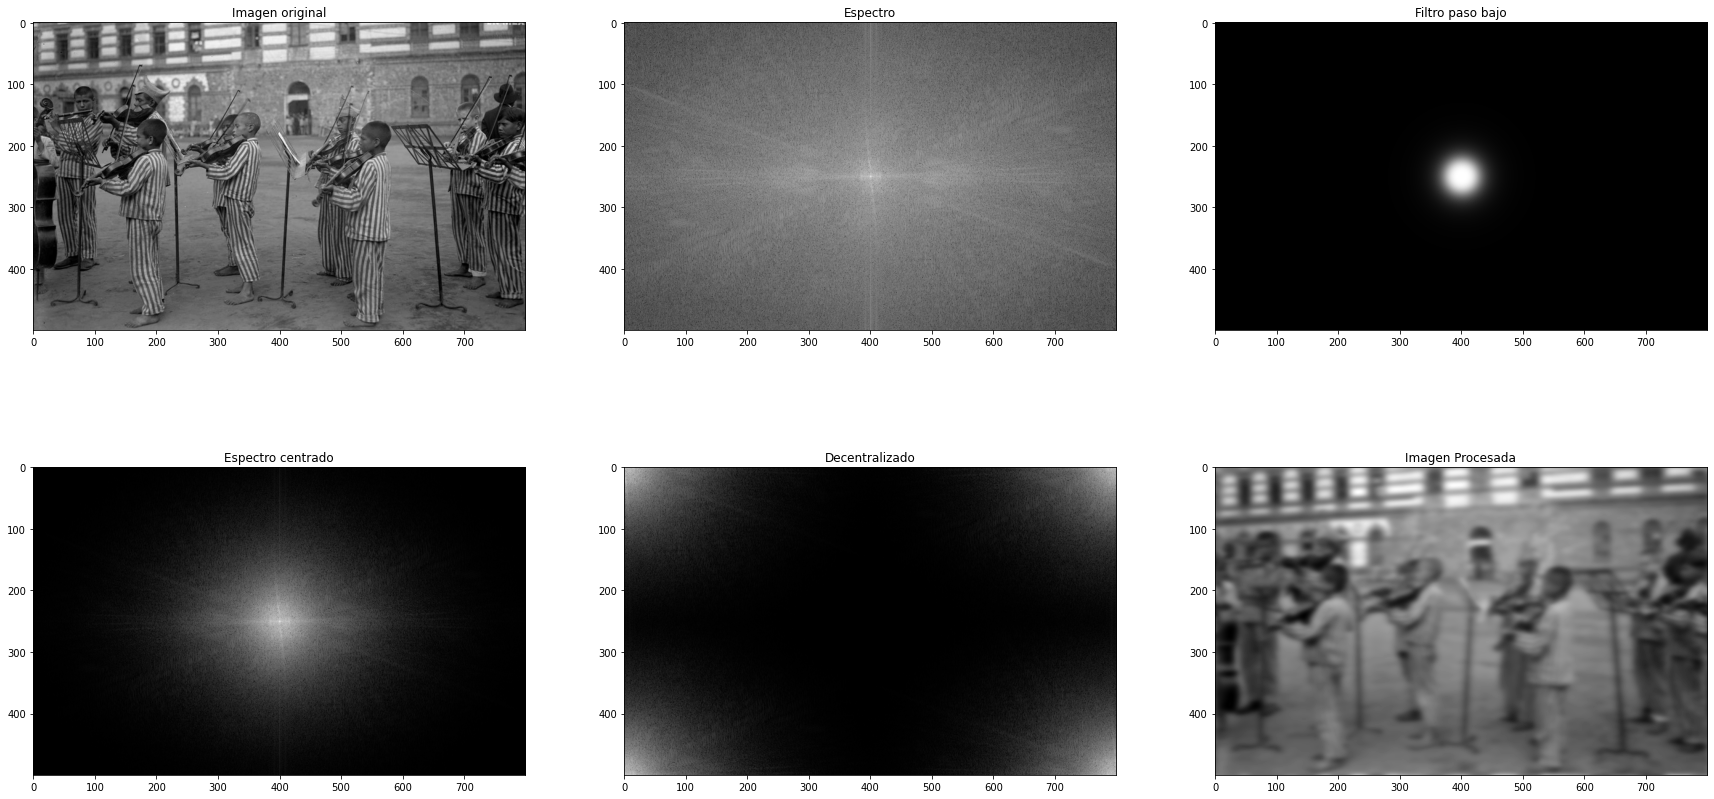

In [72]:
Do = 30 # frecuencia de corte
n=2

img = X
original = fft2(img)
center = fftshift(original)

#plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(X, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

LowPass = butterworthLP(Do,img.shape,n)
plt.subplot(233), plt.imshow(np.abs(LowPass), "gray"), plt.title("Filtro paso bajo")

LowPassCenter = center * butterworthLP(Do,img.shape,n)
plt.subplot(234), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Espectro centrado")

LowPass = ifftshift(LowPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralizado")

inverse_LowPass = ifft2(LowPass)
plt.subplot(236), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Imagen Procesada")

plt.show()

Butterworth, se observa que a varios cambios de frecuencia de corte en aumento (D0), el mismo se mantiene dejando pasar solo las frecuencias bajas y eliminando
las altas, No se observa gran variacion en la imagen procesada cuando D0 aumenta, es decir cuando aumentamos de 20 a 50 la imagen procesada se manteniene muy similar. Con un D0= 5 La imagen es muy distorcioanda. Se observa que al variar el orden del filtro (n), tiene un comportamiento de bajada pronunciado o tenue, cuando n es menor la imagen es mas clara a medida que n aumenta se va distorcionando.



## Filtro Gaussiano  Low Pass

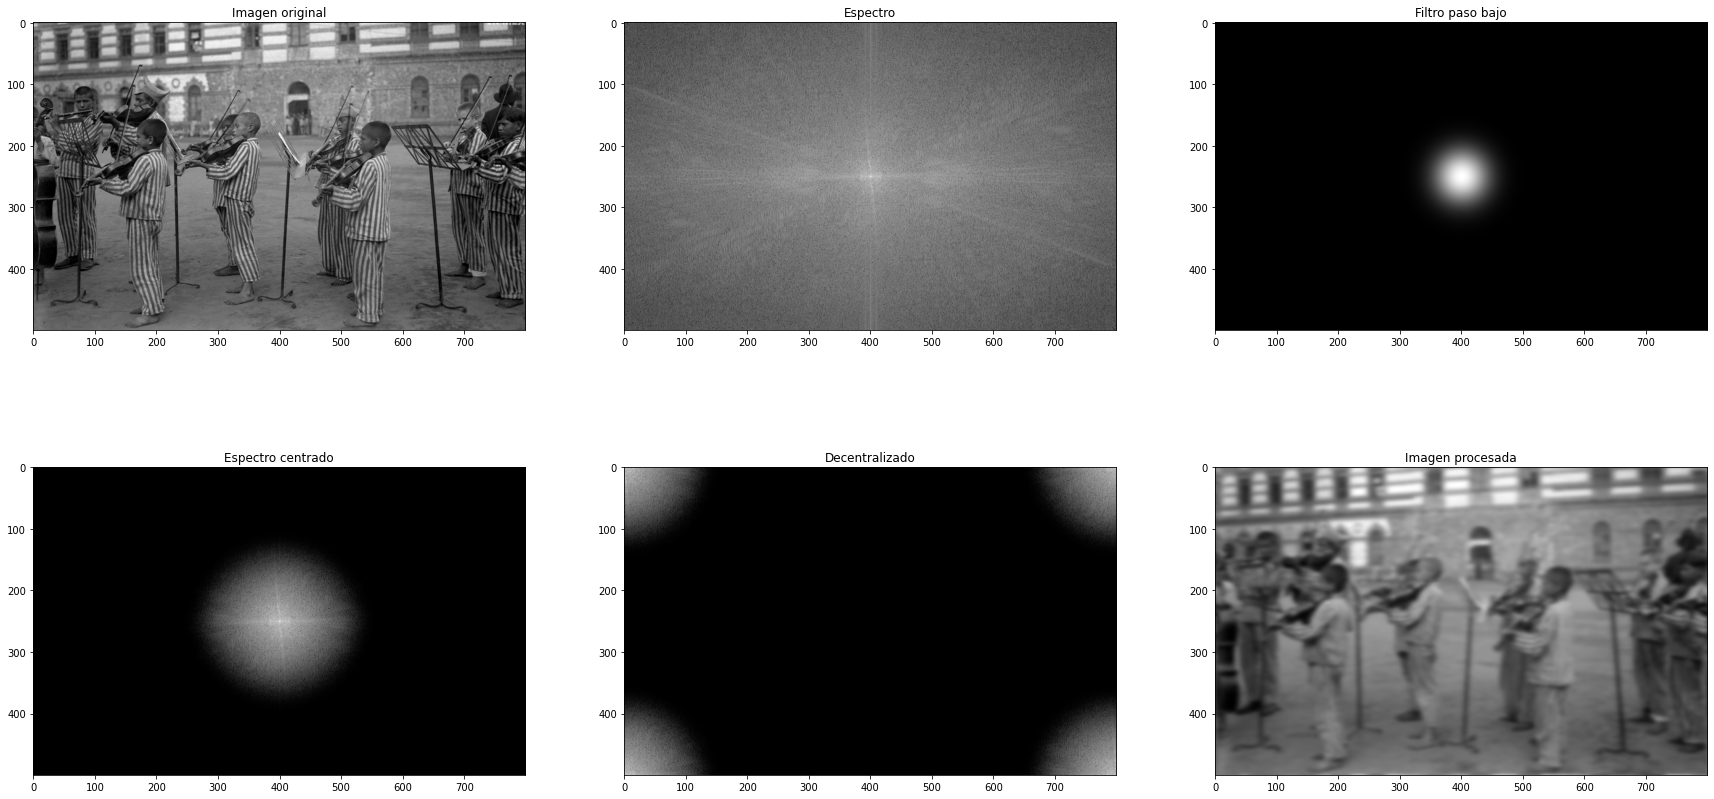

In [73]:
Do  = 30 # frecuencia de corte

img = X
original = fft2(img)
center = fftshift(original)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(X, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

LowPass = gaussianLP(Do,img.shape)
plt.subplot(233), plt.imshow(np.abs(LowPass), "gray"), plt.title("Filtro paso bajo")

LowPassCenter = center * gaussianLP(Do,img.shape)
plt.subplot(234), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Espectro centrado")

LowPass = ifftshift(LowPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralizado")

inverse_LowPass = ifft2(LowPass)
plt.subplot(236), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Imagen procesada")

plt.show()

El filtro gaussiamo preserva los bordes de la imagen. Disminuye el ruido al suavizar la imagen pero se observa que la imagen no es nitida. Al igual que los otros filtros para una frecuencia Baja la imagen se distorciona. 

## Filtro  High Pass

Los Filtros High Pass Dejan inalterables las altas frecuencias y atenúa o elimina las bajas frecuencias. El resultado en el dominio del espacio consiste en un realzado de los cambios bruscos de niveles de grises. De ahí que se use para detectar bordes. Las áreas de niveles de gris constantes o con poca variación se corresponden con las bajas frecuencias, que se suprimen.

Cuanto mayor sea el radio del círculo, mayor será el intervalo de bajas frecuencias que se elimina y, por lo tanto, más severo será el efecto del filtrado; Al contrario de los que ocurría en el diseño de filtros paso-bajo.

In [74]:
Y = cv.imread("/content/drive/MyDrive/Imagenes/Mano.jpg",0)

Este filtro suprime las frecuencias menores o iguales que un cierto valor Do, que se denomina frecuencia de corte. 


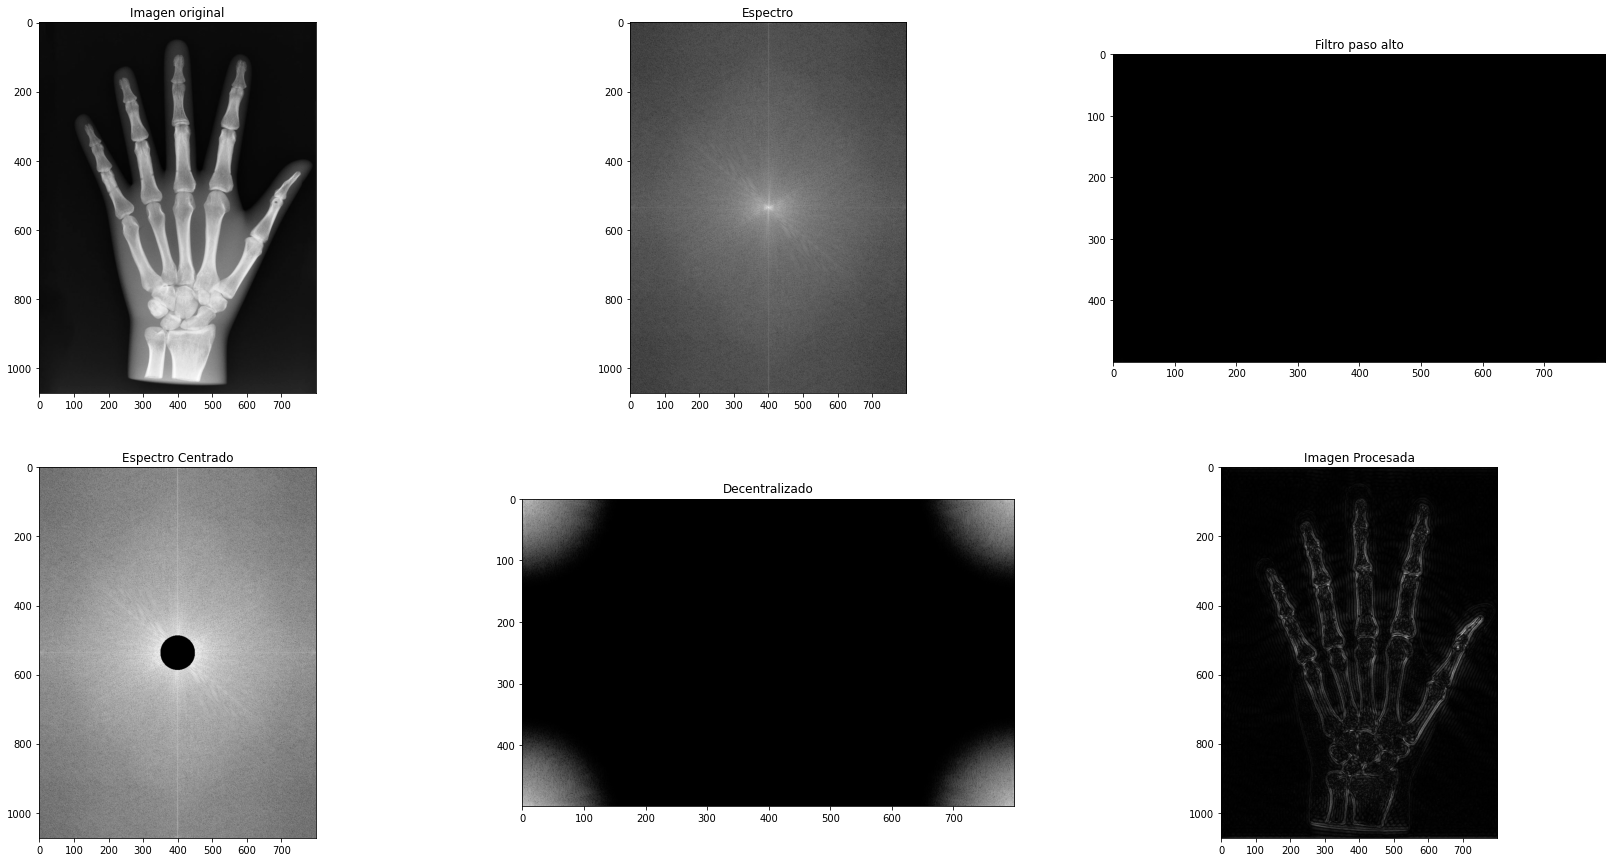

In [75]:
Do     = 50 # frecuencia de corte

img = Y
original = fft2(img)
center = fftshift(original)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(Y, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

HighPass = idealFilterHP(Do,img.shape)
plt.subplot(233), plt.imshow(np.abs(LowPass), "gray"), plt.title("Filtro paso alto")

HighPassCenter = center * idealFilterHP(Do,img.shape)
plt.subplot(234), plt.imshow(np.log(1+np.abs(HighPassCenter)), "gray"), plt.title("Espectro Centrado")

highPass = ifftshift(HighPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralizado")

inverse_highPass = ifft2(highPass)
plt.subplot(236), plt.imshow(np.abs(inverse_highPass), "gray"), plt.title("Imagen Procesada")

plt.show()

En el filtro ideal se observa que entre mayor sea la frencuencia D0, mayor va a ser el diametro del circulo y  el filtro elimina mas frecuencias bajas. 

## Filtro Butterworth High Pass

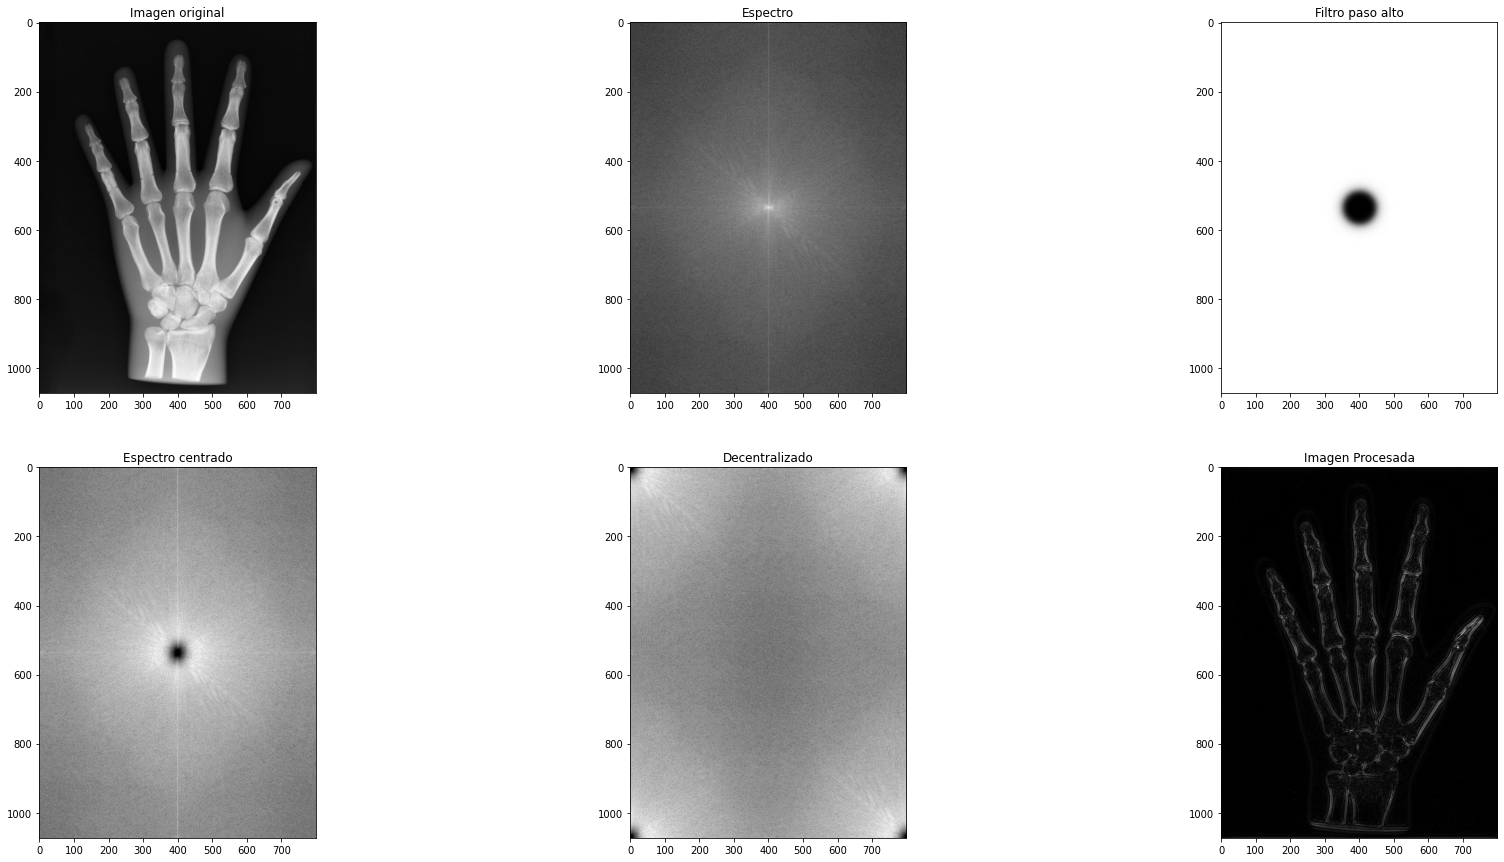

In [76]:
Do     = 50 # frecuencia de corte
n=4

img = Y
original = fft2(img)
center = fftshift(original)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(Y, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

HighPass = butterworthHP(Do,img.shape,n)
plt.subplot(233), plt.imshow(np.abs(HighPass), "gray"), plt.title("Filtro paso alto")

HighPassCenter = center * butterworthHP(Do,img.shape,n)
plt.subplot(234), plt.imshow(np.log(1+np.abs(HighPassCenter)), "gray"), plt.title("Espectro centrado")

HighPass = ifftshift(HighPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(HighPass)), "gray"), plt.title("Decentralizado")

inverse_HighPass = ifft2(HighPass)
plt.subplot(236), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Imagen Procesada")

plt.show()

Se observa que al variar el orden del filtro (n), tiene un comportamiento tenue, cuando n es menor; El filtro no elimina todas las frecuencias bajas y tiende a parecerse a un filtro gaussiano y cuando n incremeta tiende a parecerse a un filtro ideal.

## Filtro Gaussiano  High Pass

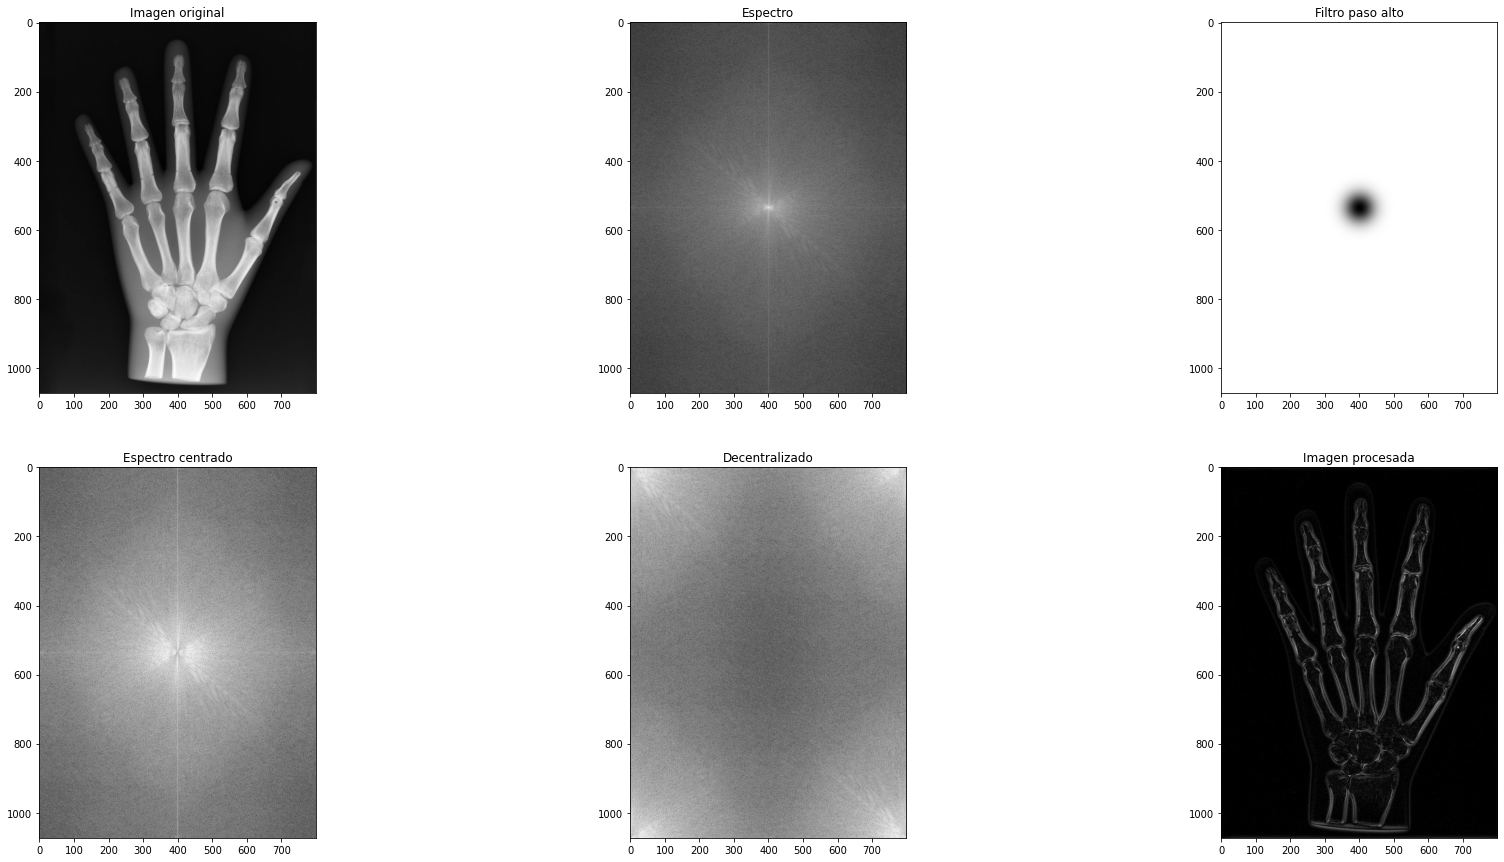

In [77]:
Do     = 30 # frecuencia de corte

img = Y
original = fft2(img)
center = fftshift(original)

plt.figure(figsize=(30,15))

plt.subplot(231), plt.imshow(Y, "gray"), plt.title("Imagen original")

plt.subplot(232), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Espectro")

HighPass = gaussianHP(Do,img.shape)
plt.subplot(233), plt.imshow(np.abs(HighPass), "gray"), plt.title("Filtro paso alto")

HighPassCenter = center * gaussianHP(Do,img.shape)
plt.subplot(234), plt.imshow(np.log(1+np.abs(HighPassCenter)), "gray"), plt.title("Espectro centrado")

HighPass = ifftshift(HighPassCenter)
plt.subplot(235), plt.imshow(np.log(1+np.abs(HighPass)), "gray"), plt.title("Decentralizado")

inverse_HighPass = ifft2(HighPass)
plt.subplot(236), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Imagen procesada")

plt.show()

Se observa que este filtro es el de mejor desempeño elimianndo el ruido comparandolo con el ideal y el butterworth.

La transformacion de imagenes en el dominio de Fourier es útil en muchas disciplinas, desde música, matemáticas, ciencias e ingeniería, está claro que su aplicación son múltiples, pero aún así la expresión matemática es bastante complicada.

# Bibliografia

[1] Gonzalez R. & Woods R. (2018). Digital Image Processing fourth edition. New York, NY: Pearson.

[2] Guardado M. Ramon. (2010).Transformada de Fourier en aplicación en el diseño de filtros digitales para el procesamiento de imágenes.

[3] Ruiz Fernández, Luis Ángel (s.f). La transformada de Fourier. Aplicación al filtrado de imágenes.

[4] Rosebrock A. (June 15, 2020). OpenCV Fast Fourier Transform (FFT) for blur detection in images and video streams. Recuperado de:  https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/



